In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from DomainPrediction.utils import helper

In [4]:
data_path = '../../../Data/al_test_experiments/Tdomain'

#### Load Data for processing

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'Tdomainr2.csv'))

In [ ]:
df.head()

In [ ]:
wt = helper.read_fasta(os.path.join(data_path, 'Tdomain_WT.fasta'), mode='str')[0]

In [ ]:
len(wt)

In [ ]:
## sanilty check sequences
check_seqs = helper.read_fasta(os.path.join(data_path, 'round_1_extraction.fasta'), mode='str')
for i, seq in enumerate(check_seqs):
    assert df['Sequence'][i] == seq

In [ ]:
def hamming_distance(seq1, seq2):
    # Ensure the sequences are of the same length
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of equal length to compute Hamming distance.")
    
    # Count differences
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [ ]:
dist_matrix = np.eye(df['Sequence'].shape[0])
sequences = df['Sequence'].to_numpy()
for i in range(sequences.shape[0]):
    for j in range(sequences.shape[0]):
        dist_matrix[i, j] = hamming_distance(sequences[i], sequences[j])

In [ ]:
dist_matrix[0,:]

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(dist_matrix)
plt.colorbar()
plt.show()

In [ ]:
dist_from_wt = []
for seq in df['Sequence']:
    dist_from_wt.append(hamming_distance(wt, seq))

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.hist(dist_from_wt)
plt.show()
print(np.array(dist_from_wt))
print(df['Name'].to_numpy())

In [ ]:
df['split_id'] = 2
df.loc[df['Name'].str.contains("ESM2"), 'split_id'] = 0
val_names = ['ESM2', 'ESM2_EP_10_1_1', 'ESM2_EP_10_1_4', 'ESM2_EP_10_1_5', 
             'ESM2_EP_10_1_6', 'ESM2_EP_10_1_8', 'ESM2_EP_10_1_9']
df.loc[df['Name'].isin(val_names), 'split_id'] = 1

In [ ]:
df.head()

In [ ]:
df.loc[df['split_id']==1, 'Name'].to_numpy()

In [ ]:
df.loc[df['split_id']==0, 'Name'].to_numpy()

In [ ]:
df_new = df[['Name', 'Sequence', 'norm_WT', 'split_id']].copy()
df_new.columns = ['name', 'seq', 'fitness_raw', 'split_id']

In [ ]:
df_new.head()

In [ ]:
n_muts = []
for i, row in df_new.iterrows():
    variant_seq = row["seq"]
    assert len(variant_seq) == len(wt)
    n = 0
    for a, b in zip(variant_seq, wt):
        if a != b:
            n += 1
    
    n_muts.append(n)

df_new['n_mut'] = n_muts

In [ ]:
df_new.head()

In [ ]:
df_new['n_mut'].unique()

In [ ]:
df_new['n_mut'].to_numpy()

In [ ]:
assert (df_new['n_mut'].to_numpy() == dist_matrix[0]).all()

In [ ]:
from collections import Counter

In [ ]:
for split in df_new['split_id'].unique():
    temp = df_new.loc[df_new['split_id']==split, 'n_mut'].unique()
    print(f'n mutation for split {split}: {temp}')
    print(Counter(df_new.loc[df_new['split_id']==split, 'n_mut']))

In [ ]:
df_new.loc[(df_new['n_mut'] == 0) & (df_new['name'] != 'WT'), ['name', 'n_mut', 'fitness_raw']]

In [ ]:
## removing the above sequences
mask = (df_new['n_mut'] == 0) & (df_new['name'] != 'WT')
df_new = df_new[~mask]

In [ ]:
temp = []
for x in df_new['fitness_raw']:
    if x == 0:
        temp.append(1e-6)
    else:
        temp.append(x)

In [ ]:
df_new['fitness_log'] = np.log(temp)

In [ ]:
# file = os.path.join(data_path, 'dataset_tdomain.csv')
# df_new.to_csv(file, index=False)

#### Load data for analysis

In [5]:
file = os.path.join(data_path, 'dataset_tdomain.csv')
df_new = pd.read_csv(file)

Text(0.5, 1.0, 'Test')

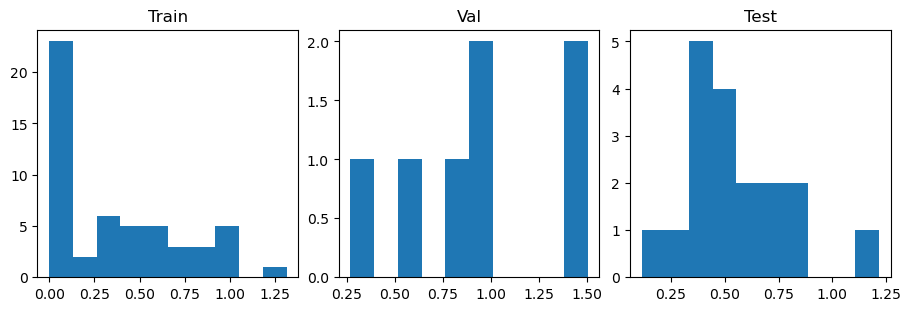

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_raw'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_raw'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_raw'])
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

Text(0.5, 1.0, 'Test')

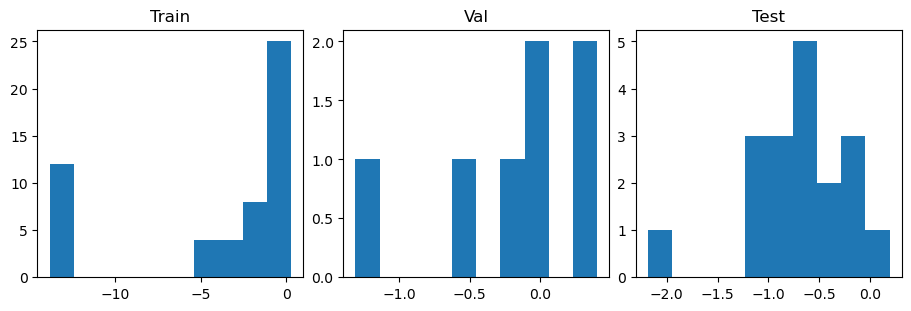

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_log'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_log'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_log'])
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

In [8]:
df_new['n_mut'].unique()

array([ 0, 44, 45, 46, 43, 41, 54, 52, 60, 59, 58,  2,  3,  5,  6,  1,  4,
       26, 33,  7, 47, 48])

In [9]:
df_new[df_new['n_mut']==0]

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.0,2,0,0.0


In [10]:
df_new.shape

(78, 6)

In [11]:
def hamming_distance(seq1, seq2):
    # Ensure the sequences are of the same length
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of equal length to compute Hamming distance.")
    
    # Count differences
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

In [13]:
dist_matrix = np.eye(df_new['seq'].shape[0])
sequences = df_new['seq'].to_numpy()
for i in range(sequences.shape[0]):
    for j in range(sequences.shape[0]):
        dist_matrix[i, j] = hamming_distance(sequences[i], sequences[j])

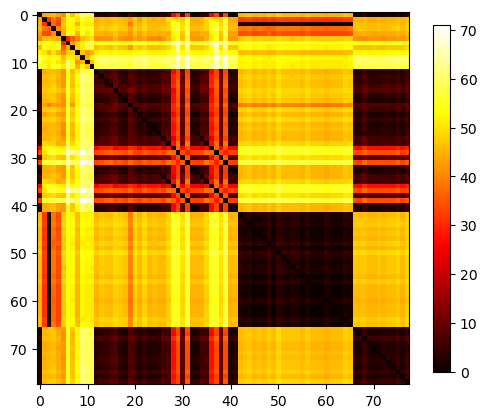

In [20]:
plt.figure(figsize=(6,6))
plt.imshow(dist_matrix, cmap='hot')
plt.colorbar(shrink=0.75)
plt.show()

In [21]:
df_new['name'].to_numpy()

array(['WT', 'ESM1', 'ESM2', 'ESM3', 'ESM4', 'IN1', 'IN2', 'IN3', 'IN4',
       'IN5', 'IN6', 'IN7', 'GxpS_DESIGN-1', 'GxpS_DESIGN-3',
       'GxpS_DESIGN-4', 'GxpS_DESIGN-5', 'GxpS_DESIGN-6', 'GxpS_DESIGN-7',
       'GxpS_DESIGN-8', 'GxpS_DESIGN-9', 'GxpS_DESIGN-11',
       'GxpS_DESIGN-14', 'GxpS_DESIGN-16', 'GxpS_DESIGN-17',
       'GxpS_DESIGN-18', 'GxpS_DESIGN-19', 'GxpS_DESIGN-20',
       'GxpS_DESIGN-21', 'GxpS_DESIGN-22', 'GxpS_DESIGN-23',
       'GxpS_DESIGN-24', 'GxpS_DESIGN-25', 'GxpS_DESIGN-26',
       'GxpS_DESIGN-27', 'GxpS_DESIGN-20', 'GxpS_DESIGN-21',
       'GxpS_DESIGN-22', 'GxpS_DESIGN-23', 'GxpS_DESIGN-24',
       'GxpS_DESIGN-25', 'GxpS_DESIGN-26', 'GxpS_DESIGN-27',
       'ESM2_EP_10_1_1', 'ESM2_EP_10_1_4', 'ESM2_EP_10_1_5',
       'ESM2_EP_10_1_6', 'ESM2_EP_10_1_8', 'ESM2_EP_10_1_9',
       'ESM2_EP_10_1_10', 'ESM2_EP_10_1_11', 'ESM2_EP_10_1_12',
       'ESM2_EP_10_1_13', 'ESM2_EP_10_1_14', 'ESM2_EP_10_1_15',
       'ESM2_EP_10_1_16', 'ESM2_EP_10_1_17', 'ESM2_EP_

Text(0.5, 1.0, 'Test')

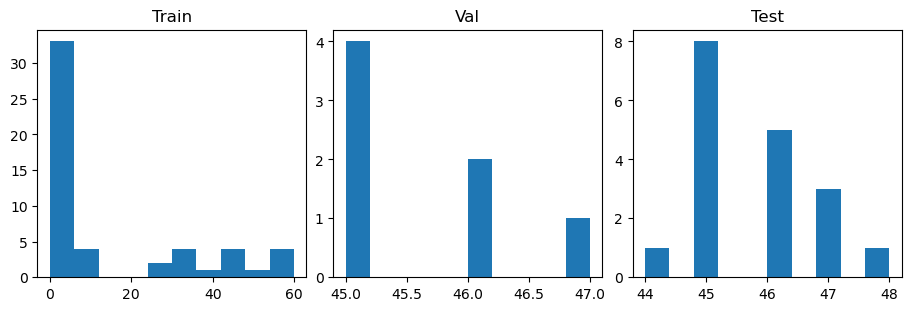

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'n_mut'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'n_mut'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'n_mut'])
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')